<h1>Mohammad Fakih W7NTTM</h1>

<p>You operate a large water treatment facility where machines are equipped with sensors and actuators. To address issues such as detecting attacks on your sensors, you have decided to implement machine learning solutions. This requires both a model architecture and training data; however, the data will not be available all at once but will instead be provided continuously. Consequently, our model needs to learn continuously rather than being trained just once. In this report, we will collect sensor readings over seven consecutive days and divide them into different splits to mimic the real-life data flow. We will then train our model on each split separately. </br>Question 1: Will catastrophic forgetting occur, leading to poor performance?
</br>Question 2: How do memory and time performance compare? Is it more efficient to train the model on all data at once or to split the data intentionally in terms of memory and time resources?</p>

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.models import Sequential
from keras import metrics
import keras
import tensorflow as tf
import os
#from scikeras.wrappers import KerasRegressor
#from sklearn.model_selection import GridSearchCV
from keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout
import time
from memory_profiler import memory_usage
import psutil
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam
import psutil
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [2]:
def dataEngineering(filepath, scaler):
    #let me now split the data into sensors and actuators and the normalize the sensors
    actuators_NAMES=['MV101', 'P101','P102', 'MV201', 'P201','P202', 'P203', 'P204', 'P205', 'P206', 'MV301','MV302','MV303','MV304','P301', 'P302', 'P401','P402','P403', 'P404', 'UV401', 'P501', 'P502','P601', 'P602','P603']
    DF = pd.read_csv(filepath)
    DF.set_index('Timestamp', inplace=True)
    #REMOVING THE LAST COLUMN
    DF= DF.iloc[:, :-1]
    sensors= DF.drop(actuators_NAMES, axis=1)
    actuators= DF[actuators_NAMES]
    scaler.fit(sensors)
    # Transform the data using the scaler
    normalized_sensors = scaler.transform(sensors)
    # Convert the normalized data back to a DataFrame
    normalized_sensors = pd.DataFrame(normalized_sensors, columns=sensors.columns)
    actuators_dummies=actuators
    for actuator in actuators_NAMES:
      actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])
      actuators_dummies= pd.get_dummies(actuators_dummies, columns=[actuator],dtype=int)
    normalized_sensors.index=actuators_dummies.index
    allData= pd.concat([normalized_sensors, actuators_dummies], axis=1)
    return allData

In [3]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

In [4]:
def generate_datasets_for_training2(data, window_size):
    _l = len(data)
    # Adjust length to be divisible by window size
    adjusted_length = _l - (_l % window_size)
    data = data.iloc[:adjusted_length]

    Xs = []
    for i in range(0, adjusted_length, window_size):
        Xs.append(data[i:i + window_size].values)
    
    # Convert list to numpy array
    Xs = np.array(Xs)
    
    return (Xs.shape[1], Xs)


In [6]:
filepath = "D://Msc_Data_Science_1//Semester 2//Data science lab 1//LSTM data//SWaT_Dataset_Normal_v0 2.csv"
scaler = MinMaxScaler()
data = dataEngineering(filepath, scaler)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_22232\4273617739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])


In [7]:
feats, tr_x = generate_datasets_for_training2(data,10)

In [8]:
tr_x.shape

(49680, 10, 103)

In [13]:
# Define the ratio of train and test split
train_ratio = 0.8  # 80% for training, 20% for testing

# Split the data into train and test sets using train_test_split
train_data, test_data = train_test_split(tr_x, train_size=train_ratio, random_state=42)

In [14]:
splits = np.array_split(train_data, 10)

In [67]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # GPUs are available
    for gpu in gpus:
        print("Name:", gpu.name, "  Type:", gpu.device_type)
else:
    print("No GPU available")

Name: /physical_device:GPU:0   Type: GPU


In [68]:
#prev LR
#00044007375

<h1>without splitting</h1>

In [27]:

# Callback to monitor memory usage
class MemoryUsageCallback(Callback):
    def __init__(self):
        self.memory_usage = []

    def on_epoch_end(self, epoch, logs=None):
        process = psutil.Process()
        self.memory_usage.append(process.memory_info().rss)

# Function to build the LSTM model with batch normalization
def build_model_with_batch_norm():
    model = Sequential()

    # Encoder part
    model.add(LSTM(96, activation='relu', input_shape=(10, 103), return_sequences=True, name='encoder_1'))
    model.add(BatchNormalization())
    
    model.add(LSTM(32, activation='relu', return_sequences=True, name='encoder_2'))
    model.add(BatchNormalization())
    
    model.add(LSTM(16, activation='relu', return_sequences=False, name='encoder_3'))
    model.add(BatchNormalization())
    
    model.add(RepeatVector(10, name='encoder_decoder_bridge'))
    
    # Decoder part
    model.add(LSTM(16, activation='relu', return_sequences=True, name='decoder_1'))
    model.add(BatchNormalization())
    
    model.add(LSTM(32, activation='relu', return_sequences=True, name='decoder_2'))
    model.add(BatchNormalization())
    
    model.add(LSTM(96, activation='relu', return_sequences=True, name='decoder_3'))
    model.add(BatchNormalization())
    
    model.add(TimeDistributed(Dense(103, name='output_layer')))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

# Instantiate and summarize the model
model = build_model_with_batch_norm()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 10, 96)            76800     
                                                                 
 batch_normalization_30 (Bat  (None, 10, 96)           384       
 chNormalization)                                                
                                                                 
 encoder_2 (LSTM)            (None, 10, 32)            16512     
                                                                 
 batch_normalization_31 (Bat  (None, 10, 32)           128       
 chNormalization)                                                
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 batch_normalization_32 (Bat  (None, 16)              

In [30]:
import time
from memory_profiler import memory_usage

# Function to train the model and return history
def train_model():
    history = model.fit(train_data, train_data, epochs=50, validation_split=0.2, callbacks=[early_stop])
    return history

# Measure time and memory usage
start_time = time.time()
mem_usage, result = memory_usage((train_model, ), retval=True, interval=0.1, timeout=None)
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

# Print results
print(f"Time elapsed: {elapsed_time:.2f} seconds")
print(f"Memory usage: {max(mem_usage) - min(mem_usage):.2f} MiB")

Epoch 1/50
994/994 [==============================] - 333s 326ms/step - loss: 0.0531 - val_loss: 0.0084
Epoch 2/50
994/994 [==============================] - 313s 315ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 3/50
994/994 [==============================] - 321s 323ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 4/50
994/994 [==============================] - 349s 351ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 5/50
994/994 [==============================] - 338s 340ms/step - loss: 0.0040 - val_loss: 0.0674
Epoch 6/50
994/994 [==============================] - 313s 314ms/step - loss: 0.0042 - val_loss: 0.0029
Time elapsed: 1968.91 seconds


TypeError: 'numpy.float64' object is not callable

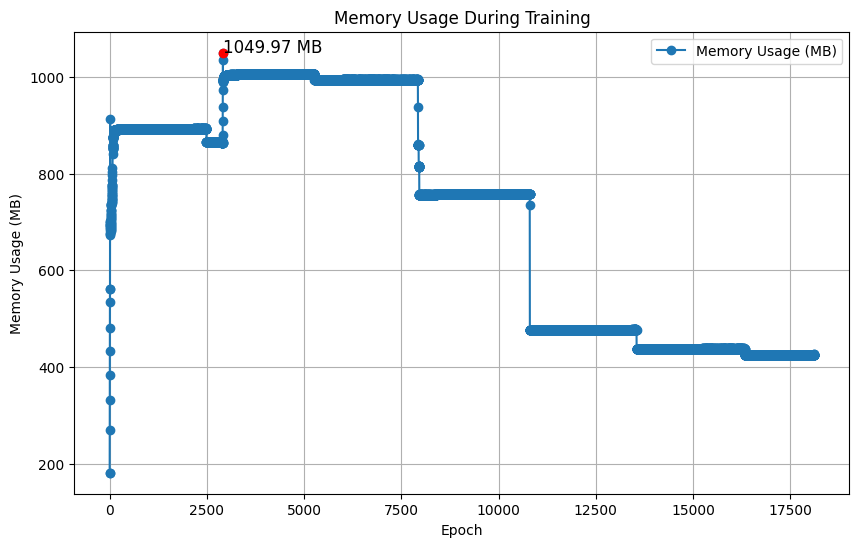

In [33]:
# Example memory usage data (in bytes)
memory_usages3 = np.array(mem_usage)
# # Convert memory usage from bytes to megabytes
# memory_usages_mb2 = memory_usages3 / (1024 * 1024)

# Find the index of the maximum memory usage
max_index = np.argmax(memory_usages3)
max_value = memory_usages3[max_index]

# Plot the memory usage
plt.figure(figsize=(10, 6))
plt.plot(memory_usages3, label='Memory Usage (MB)', marker='o')

# Highlight the maximum memory usage
plt.plot(max_index, max_value, 'ro')  # Red dot for the max value
plt.text(max_index, max_value, f'{max_value:.2f} MB', fontsize=12, ha='left')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage During Training')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

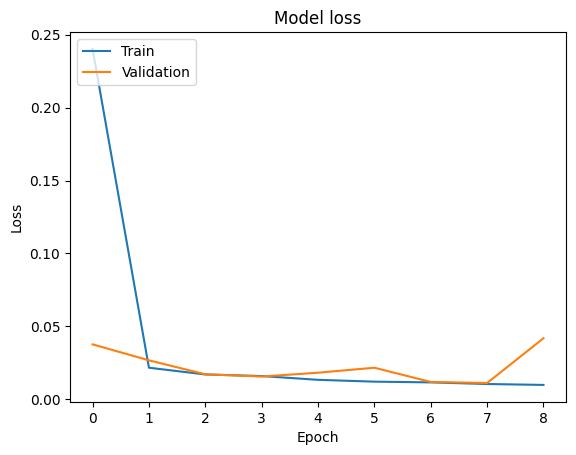

In [36]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

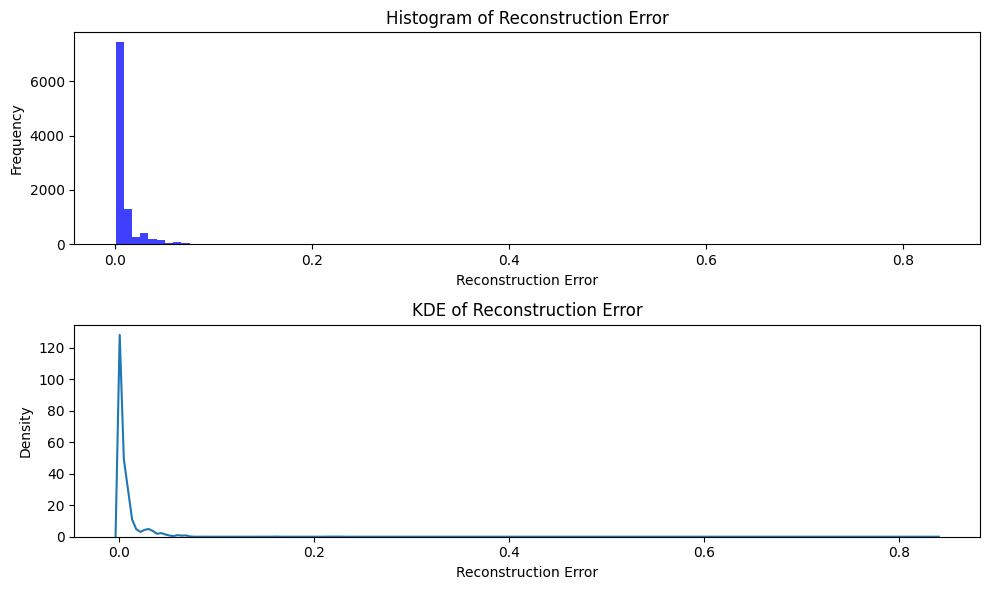

In [37]:
predicted_test = model.predict(test_data, verbose=0)
# Calculate the mean absolute error for each prediction
calculated_mse = np.mean((predicted_test - test_data) ** 2, axis=(1, 2))
# Plot the distribution of the reconstruction error
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(calculated_mse, bins=100, alpha=0.75, color='blue')
plt.title('Histogram of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

# KDE plot
plt.subplot(2, 1, 2)
sns.kdeplot(calculated_mse, bw_adjust=0.5)
plt.title('KDE of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [38]:
max = np.max(calculated_mse)
mean = np.mean(calculated_mse)
std_dev = np.std(calculated_mse)
print(f'Maximum Error: {max}')
print(f'Mean is: {mean}')
print(f'mean plus std {mean + 3 * std_dev}')
# Calculate the quartiles
Q1 = np.percentile(calculated_mse, 25)
Q2 = np.percentile(calculated_mse, 50)  # This is also the median
Q3 = np.percentile(calculated_mse, 75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (50th percentile / median): {Q2}")
print(f"Q3 (75th percentile): {Q3}")
IQR= Q3-Q1
possible_threshold = Q3 + 1.5 * IQR 
print(f'the possible threshold is: {possible_threshold}')
percentile_90 = np.percentile(calculated_mse, 90)
print(percentile_90)


Maximum Error: 0.83651383397717
Mean is: 0.008461714432755174
mean plus std 0.05803220715100617
Q1 (25th percentile): 0.001499574267780551
Q2 (50th percentile / median): 0.0035973897040119376
Q3 (75th percentile): 0.009286510458385149
the possible threshold is: 0.020966914744292048
0.022630909903303773


In [41]:
#save our model 
model.save('finalWithout.h5')

<h1>Let us split our data now and do a basic training (no handling for catastrophic forgetting using LwF) </h1>

In [64]:
modelNoLwf = build_model_with_batch_norm()

In [66]:
# Function to train the model on a given split and return history
def train_model(split, model):
    history = modelNoLwf.fit(x=split,
                        y=split,
                        epochs=100,
                        batch_size=16,
                        shuffle=False,
                        validation_split=0.2,
                        callbacks=[early_stop])
    return history
train_losses = []
val_losses = []
times = []
memory_usages = []
for i, split in enumerate(splits):
    print(f"Training on split {i + 1}/{len(splits)}")

    # Measure time and memory before training
    start_time = time.time()
    mem_usage, history = memory_usage((train_model, (split, modelNoLwf)), retval=True, interval=0.1, timeout=None)
    end_time = time.time()
    
    # Calculate elapsed time and memory usage
    elapsed_time = end_time - start_time
    memory_usage_value = max(mem_usage) - min(mem_usage)
    
    times.append(elapsed_time)
    memory_usages.append(memory_usage_value)
    
    # Store the losses for this split
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

# Save the model weights
model.save_weights('modelNoLwf.h5')

# Print the time and memory consumption
for i, (time_consumed, memory_used) in enumerate(zip(times, memory_usages)):
    print(f"Split {i + 1}: Time consumed = {time_consumed:.2f} seconds, Memory used = {memory_used:.2f} MiB")

# Optionally, plot the losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training on split 1/10
Epoch 1/100
  4/199 [..............................] - ETA: 50s - loss: 0.0152

KeyboardInterrupt: 

<h1>Let us split our data now and mitigate the catastrophic forgetting using LwF </h1>

In [17]:

# Function to build the LSTM model with batch normalization
def build_model_with_batch_norm():
    model = Sequential()
    # Encoder part
    model.add(LSTM(96, activation='relu', input_shape=(10, 103), return_sequences=True, name='encoder_1'))
    model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=True, name='encoder_2'))
    model.add(BatchNormalization())
    model.add(LSTM(16, activation='relu', return_sequences=False, name='encoder_3'))
    model.add(BatchNormalization())
    model.add(RepeatVector(10, name='encoder_decoder_bridge'))
    # Decoder part
    model.add(LSTM(16, activation='relu', return_sequences=True, name='decoder_1'))
    model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=True, name='decoder_2'))
    model.add(BatchNormalization())
    model.add(LSTM(96, activation='relu', return_sequences=True, name='decoder_3'))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(103, name='output_layer')))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model
# Instantiate and summarize the model
model = build_model_with_batch_norm()
model.summary()


# Callback to monitor memory usage
class MemoryUsageCallback(Callback):
    def __init__(self):
        self.memory_usage = []

    def on_epoch_end(self, epoch, logs=None):
        process = psutil.Process()
        self.memory_usage.append(process.memory_info().rss)

# Example data splits (replace with your actual data)
# Assume `splitsPrime` is a list of numpy arrays each of shape (N, 10, 103)
# Example: splitsPrime = [np.random.rand(320, 10, 103) for _ in range(10)]

# Instantiate lists to store metrics
train_losses = []
val_losses = []
memory_usages = []
times = []

for i, split in enumerate(splits):
    # Reset memory usage callback for each split
    memory_usage_cbk = MemoryUsageCallback()

    if i == 0:
        # Train the model normally for the first split
        start_time = time.time()
        history = model.fit(x=split, y=split, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop, memory_usage_cbk])
        end_time = time.time()
    else:
        # Implement Learning Without Forgetting for subsequent splits
        # Freeze the old model
        old_model = tf.keras.models.clone_model(model)
        old_model.set_weights(model.get_weights())
        old_model.trainable = False
        
        # Custom training loop with knowledge distillation
        loss_fn_new_task = tf.keras.losses.MeanSquaredError()
        loss_fn_distill = tf.keras.losses.MeanSquaredError()
        optimizer = Adam()

        # Prepare a dataset object for training
        train_dataset = tf.data.Dataset.from_tensor_slices((split, split)).batch(32)
        
        # Custom training loop
        start_time = time.time()
        epochs = 10
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs} for split {i+1}")
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    # Forward pass
                    logits_new = model(x_batch_train, training=True)
                    logits_old = old_model(x_batch_train, training=False)

                    # Calculate the losses
                    loss_new_task = loss_fn_new_task(y_batch_train, logits_new)
                    loss_distill = loss_fn_distill(logits_new, logits_old)
                    loss = loss_new_task + loss_distill

                # Calculate gradients and update the model
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

            print(f"Loss: {loss.numpy()}")

        end_time = time.time()

    # Store metrics for the split
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])
    memory_usages.extend(memory_usage_cbk.memory_usage)
    times.append(end_time - start_time)

    # Save the model's weights after training on each split
    model.save_weights(f'LwFdelete{i+1}_weights.h5')

    # Reset memory usage callback
    memory_usage_cbk.memory_usage = []

print("Training complete for all splits.")

# Print final metrics
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
print(f"Memory Usages: {memory_usages}")
print(f"Times: {times}")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 10, 96)            76800     
                                                                 
 batch_normalization_24 (Bat  (None, 10, 96)           384       
 chNormalization)                                                
                                                                 
 encoder_2 (LSTM)            (None, 10, 32)            16512     
                                                                 
 batch_normalization_25 (Bat  (None, 10, 32)           128       
 chNormalization)                                                
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 batch_normalization_26 (Bat  (None, 16)              

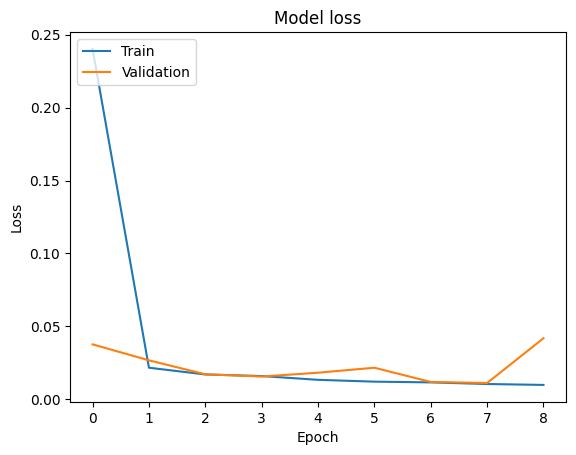

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

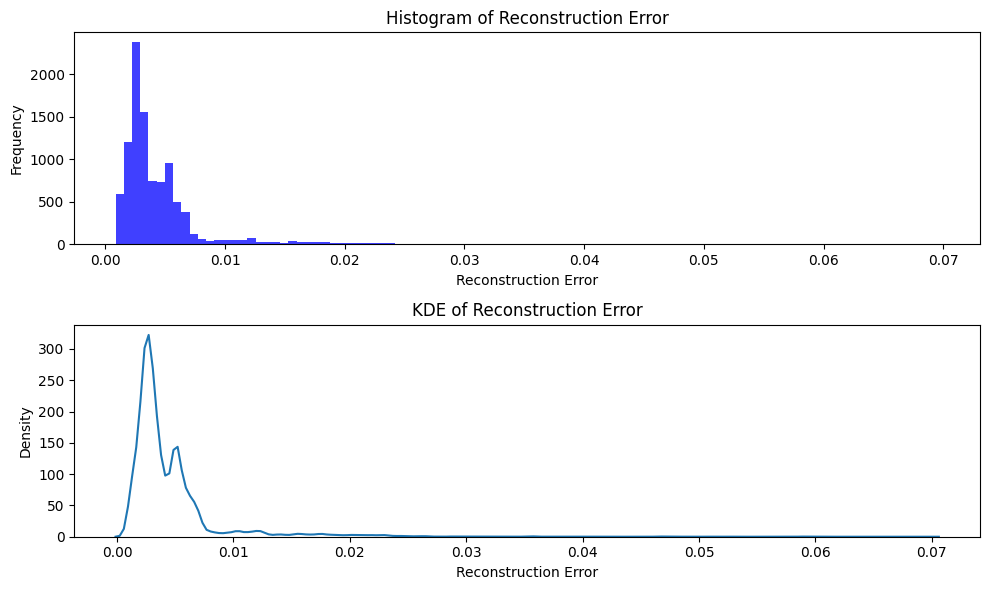

In [21]:
predicted_test = model.predict(test_data, verbose=0)
# Calculate the mean absolute error for each prediction
calculated_mse = np.mean((predicted_test - test_data) ** 2, axis=(1, 2))
# Plot the distribution of the reconstruction error
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(2, 1, 1)
plt.hist(calculated_mse, bins=100, alpha=0.75, color='blue')
plt.title('Histogram of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')

# KDE plot
plt.subplot(2, 1, 2)
sns.kdeplot(calculated_mse, bw_adjust=0.5)
plt.title('KDE of Reconstruction Error')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [22]:
max = np.max(calculated_mse)
mean = np.mean(calculated_mse)
std_dev = np.std(calculated_mse)
print(f'Maximum Error: {max}')
print(f'Mean is: {mean}')
print(f'mean plus std {mean + 3 * std_dev}')

Maximum Error: 0.06962269609764793
Mean is: 0.00442912945506738
mean plus std 0.01673269208427931


In [23]:
# Calculate the quartiles
Q1 = np.percentile(calculated_mse, 25)
Q2 = np.percentile(calculated_mse, 50)  # This is also the median
Q3 = np.percentile(calculated_mse, 75)

print(f"Q1 (25th percentile): {Q1}")
print(f"Q2 (50th percentile / median): {Q2}")
print(f"Q3 (75th percentile): {Q3}")

Q1 (25th percentile): 0.0024566661006176697
Q2 (50th percentile / median): 0.0031996346739240197
Q3 (75th percentile): 0.005099921531348509


In [24]:
IQR= Q3-Q1
possible_threshold = Q3 + 1.5 * IQR 
print(f'the possible threshold is: {possible_threshold}')
percentile_90 = np.percentile(calculated_mse, 90)
print(percentile_90)

the possible threshold is: 0.009064804677444768
0.006859834012072326


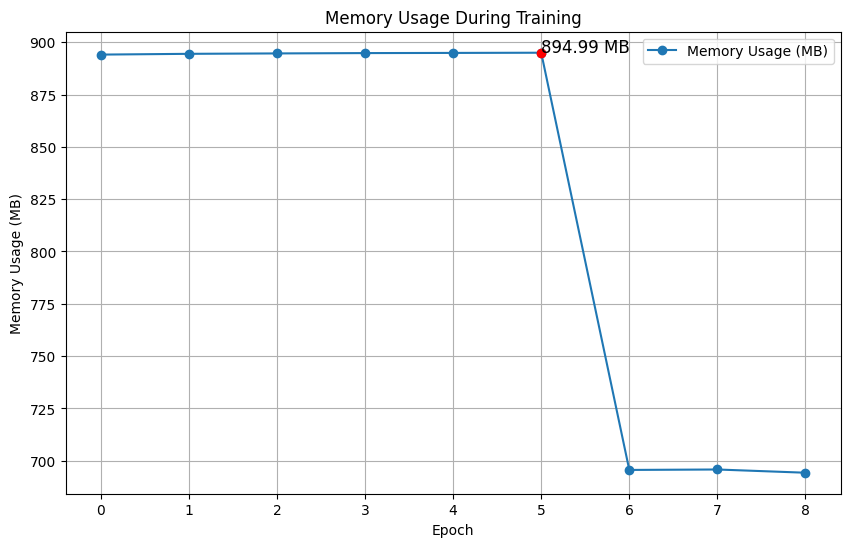

In [25]:
# Example memory usage data (in bytes)
memory_usages2 = np.array(memory_usages)
# Convert memory usage from bytes to megabytes
memory_usages_mb = memory_usages2 / (1024 * 1024)

# Find the index of the maximum memory usage
max_index = np.argmax(memory_usages_mb)
max_value = memory_usages_mb[max_index]

# Plot the memory usage
plt.figure(figsize=(10, 6))
plt.plot(memory_usages_mb, label='Memory Usage (MB)', marker='o')

# Highlight the maximum memory usage
plt.plot(max_index, max_value, 'ro')  # Red dot for the max value
plt.text(max_index, max_value, f'{max_value:.2f} MB', fontsize=12, ha='left')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage During Training')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [26]:
#let us check time
total = 0 
for i in times:
    total = total+i 
print(f'the total time taken is: {total} seconds')

the total time taken is: 13591.358980178833 seconds


<h1>Shall we visualize some anomalies?</h1>

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

def showSensors2(sensors, data, start_row, end_row, x=None, y=None):
    """
    Plots the values of specified sensors from a dataframe within a given row range and draws vertical lines at specified positions.

    Parameters:
    sensors (list of str): List of sensor names (columns) to plot.
    data (pd.DataFrame): DataFrame containing the sensor data.
    start_row (int): The starting row of the data to consider.
    end_row (int): The ending row of the data to consider.
    x (int, optional): The x-coordinate for the first vertical line.
    y (int, optional): The x-coordinate for the second vertical line.
    """
    # Subset the data based on the given row range
    data_subset = data.iloc[start_row:end_row]

    # Plot the sensor values
    plt.figure(figsize=(15, 10))
    for sensor in sensors:
        if sensor in data_subset.columns:
            plt.plot(data_subset[sensor], label=sensor)
        else:
            print(f"Warning: {sensor} not found in the data columns.")
    
    # Draw vertical lines if x and y are provided
    if x is not None:
        plt.axvline(x=x, color='r', linestyle='--', label=f'x = {x}')
    if y is not None:
        plt.axvline(x=y, color='b', linestyle='--', label=f'y = {y}')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Sensor Value')
    plt.title('Sensor Values Over Time')
    plt.legend()
    plt.show()


In [60]:
#here we'll spot the  anomalies and retriever their indexes 
def find_consecutive_ones(arr):
    """
    Find pairs of indices where each pair (x, y) represents the start and end indices of consecutive 1s.

    Parameters:
    arr (list of int): List of 0s and 1s.

    Returns:
    list of lists: Each inner list contains two integers representing the start and end indices of consecutive 1s.
    """
    result = []
    n = len(arr)
    i = 0

    while i < n:
        if arr[i] == 1:
            start = i
            while i < n and arr[i] == 1:
                i += 1
            end = i - 1
            result.append([start, end])
        i += 1

    return result
find_consecutive_ones(labels)

[[1754, 2693],
 [3068, 3510],
 [4920, 5302],
 [6459, 6848],
 [7255, 7450],
 [7705, 8133],
 [11410, 12373],
 [15380, 16100],
 [73800, 74520],
 [90685, 90917],
 [92140, 92570],
 [93445, 93720],
 [103092, 103808],
 [115843, 116101],
 [116143, 116537],
 [117000, 117720],
 [132918, 133380],
 [142954, 143650],
 [172268, 172588],
 [172910, 173521],
 [198296, 199740],
 [227828, 263727],
 [279120, 279240],
 [280060, 281230],
 [302653, 303019],
 [347679, 348279],
 [361191, 361634],
 [371479, 371579],
 [371855, 372335],
 [389680, 390219],
 [436541, 437009],
 [437417, 437697],
 [438147, 438547],
 [438621, 438917],
 [443501, 445190]]

<h3>Crucial Observation</h3>
<p>1) the sensors sometimes do not immediately respond to the attack</p>
<p>2) the sensors sometimes stay under the abnormal situation for few seconds even after the attack finishes/p>

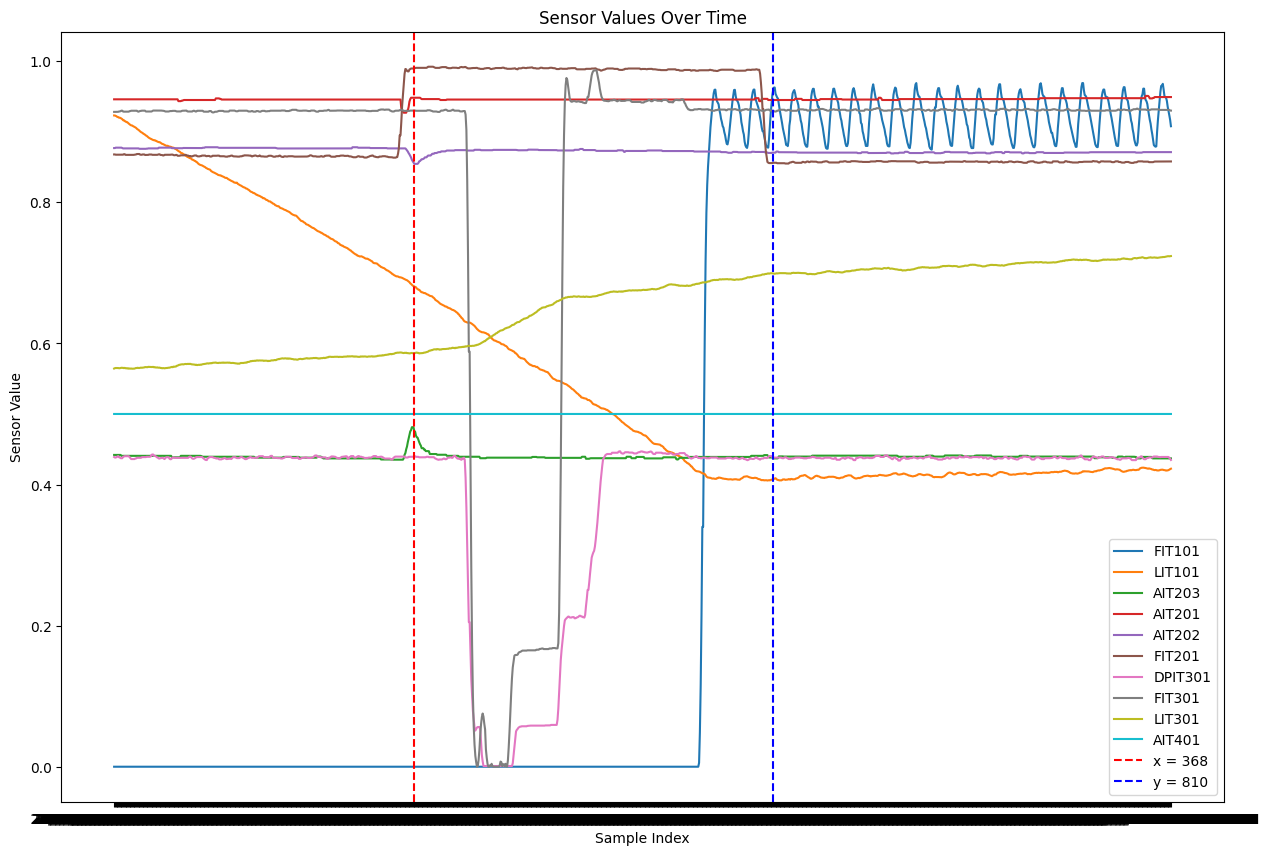

In [61]:
showSensors2(["FIT101", "LIT101", "AIT203", "AIT201", "AIT202", "FIT201", "DPIT301", "FIT301", "LIT301", "AIT401"],
             mixed_data_without_label, start_row=2700, end_row=4000, x= 3068-2700 , y= 3510-2700)

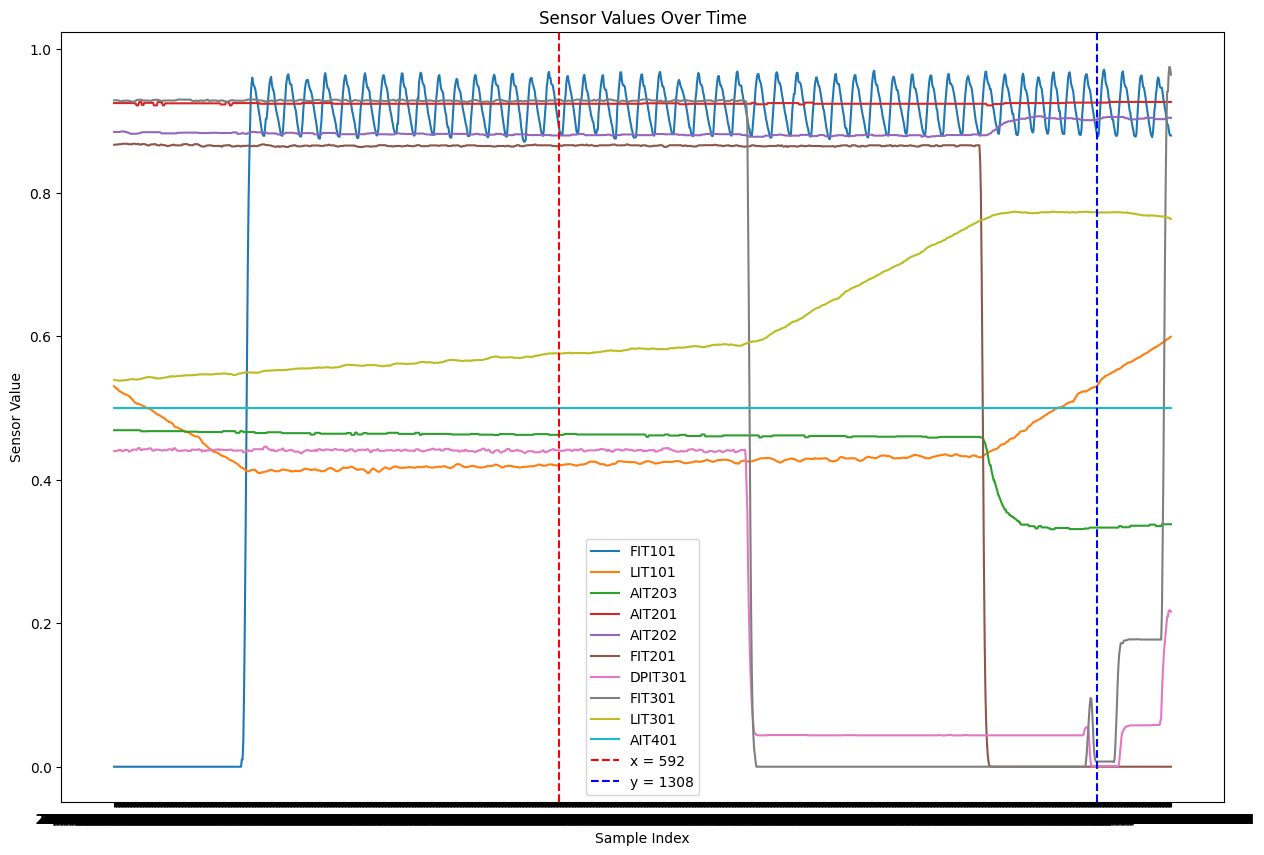

In [62]:
showSensors2(["FIT101", "LIT101", "AIT203", "AIT201", "AIT202", "FIT201", "DPIT301", "FIT301", "LIT301", "AIT401"],
             mixed_data_without_label, start_row=102500, end_row=103908, x= 103092-102500 , y= 103808-102500)


<h1>Now let us Check for anomaly detection</h1>

In [42]:
mixed_data= "D://Msc_Data_Science_1//Semester 2//Data science lab 1//LSTM data//SWaT_Dataset_Attack_v0 - Copy 2.csv"
scaler= MinMaxScaler()
mixed_data_without_label = dataEngineering(mixed_data, scaler)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_22232\4273617739.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actuators_dummies[actuator]= pd.Categorical(actuators_dummies[actuator], categories=[0, 1, 2])


In [43]:
#let us now recreate the function that also splits the data
def Create_data(data,labels,timestep):
  data= data[:int(len(data)/timestep)*timestep]
  labels= labels[:int(len(labels)/timestep)*timestep]
  anomalies=[]
  x=[]
  _l = len(data)
  for i in range (0, _l, timestep):
    x.append(data[i:i+timestep])
    #fi we have got at least 5 anomalies we will consider the entire series to be an anomaly
    if((labels.iloc[i:i+timestep]).sum()>=9):
      anomalies.append(1)
    else:
      anomalies.append(0)
  p=np.array(x)
  return _l, p,anomalies

In [44]:
#Function that takes the an the filepath and returns a list of 0 and 1 (normal / attacks)
def labels (filepath):
    df = pd.read_csv(filepath)
    labels= df['Normal/Attack']
    #now let us consider the a ttack and the attack the same (let us replace them by 1)
    #and we will replace the normal with a zero
    labels= labels.replace({'Normal': 0, 'Attack': 1, 'A ttack':1})
    return labels 

In [45]:
labels= labels(mixed_data)

C:\Users\mfaki\AppData\Local\Temp\ipykernel_22232\2199064294.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels= labels.replace({'Normal': 0, 'Attack': 1, 'A ttack':1})


In [46]:
lenght, dataNew, anomaliesNew= Create_data(mixed_data_without_label, labels, 10)

In [47]:
predicted_seq= model.predict(dataNew)

1406/1406 [==============================] - 58s 41ms/step


In [48]:
calculated_mse = np.mean((predicted_seq - dataNew) ** 2, axis=(1,2))

In [49]:
thresholds = [x / 100.0 for x in range(0, 20)]
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomaliesNew, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'For threshold = {threshold}')
    print(f'tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')
    print(f'Precision = {precision}')
    print(f'Recall = {recall}')
    print(f'F1-Score = {f1_score}')
    print('----------------------')

For threshold = 0.0
tp: 5445, tn: 0, fp: 39546, fn: 0
Precision = 0.1210242048409682
Recall = 1.0
F1-Score = 0.21591720199857245
----------------------
For threshold = 0.01
tp: 5445, tn: 3, fp: 39543, fn: 0
Precision = 0.12103227527340624
Recall = 1.0
F1-Score = 0.21593004580334302
----------------------
For threshold = 0.02
tp: 4866, tn: 24200, fp: 15346, fn: 579
Precision = 0.24074807045319613
Recall = 0.89366391184573
F1-Score = 0.3793116888178665
----------------------
For threshold = 0.03
tp: 4446, tn: 29983, fp: 9563, fn: 999
Precision = 0.3173674066671425
Recall = 0.8165289256198347
F1-Score = 0.4570782358383879
----------------------
For threshold = 0.04
tp: 3944, tn: 35847, fp: 3699, fn: 1501
Precision = 0.5160277377992935
Recall = 0.7243342516069788
F1-Score = 0.6026894865525672
----------------------
For threshold = 0.05
tp: 3697, tn: 37913, fp: 1633, fn: 1748
Precision = 0.6936210131332082
Recall = 0.678971533516988
F1-Score = 0.6862180974477958
----------------------
For t

In [50]:
#let us check the metrics values between 0.03 and 0.05 
thresholds = [round(x, 3) for x in np.arange(0.05, 0.081, 0.001)]
F1_score_max= -1 
tpp, tnp, fpp, fnp=-1,-1,-1,-1
threshold_opt = 1
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomaliesNew, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if (f1_score>F1_score_max):
        F1_score_max=f1_score
        tpp, tnp, fpp, fnp = tp, tn, fp, fn
        threshold_opt=threshold 
print(f'for the threshold {threshold_opt}, the F1 score is {F1_score_max} and tp: {tpp}, tn: {tnp}, fp: {fpp}, fn: {fnp}')

for the threshold 0.07, the F1 score is 0.7634199134199136 and tp: 3527, tn: 39278, fp: 268, fn: 1918


<h1>let us now check for the model that was trained on the splitted dataset</h1>

In [51]:
# Instantiate and summarize the model
model2 = build_model_with_batch_norm()
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 10, 96)            76800     
                                                                 
 batch_normalization_36 (Bat  (None, 10, 96)           384       
 chNormalization)                                                
                                                                 
 encoder_2 (LSTM)            (None, 10, 32)            16512     
                                                                 
 batch_normalization_37 (Bat  (None, 10, 32)           128       
 chNormalization)                                                
                                                                 
 encoder_3 (LSTM)            (None, 16)                3136      
                                                                 
 batch_normalization_38 (Bat  (None, 16)              

In [52]:
model2.load_weights('LwFdelete10_weights.h5')

In [53]:
predicted_seq= model2.predict(dataNew)
calculated_mse = np.mean((predicted_seq - dataNew) ** 2, axis=(1,2))

1406/1406 [==============================] - 58s 40ms/step


In [54]:
thresholds = [x / 100.0 for x in range(0, 20)]
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomaliesNew, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f'For threshold = {threshold}')
    print(f'tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')
    print(f'Precision = {precision}')
    print(f'Recall = {recall}')
    print(f'F1-Score = {f1_score}')
    print('----------------------')

For threshold = 0.0
tp: 5445, tn: 0, fp: 39546, fn: 0
Precision = 0.1210242048409682
Recall = 1.0
F1-Score = 0.21591720199857245
----------------------
For threshold = 0.01
tp: 5445, tn: 64, fp: 39482, fn: 0
Precision = 0.12119660783048056
Recall = 1.0
F1-Score = 0.21619153497975066
----------------------
For threshold = 0.02
tp: 4313, tn: 31824, fp: 7722, fn: 1132
Precision = 0.3583714167012879
Recall = 0.7921028466483012
F1-Score = 0.4934782608695652
----------------------
For threshold = 0.03
tp: 3959, tn: 33294, fp: 6252, fn: 1486
Precision = 0.3877191264322789
Recall = 0.727089072543618
F1-Score = 0.5057485947879407
----------------------
For threshold = 0.04
tp: 3449, tn: 39013, fp: 533, fn: 1996
Precision = 0.866147664490206
Recall = 0.633425160697888
F1-Score = 0.7317280152752732
----------------------
For threshold = 0.05
tp: 3300, tn: 39376, fp: 170, fn: 2145
Precision = 0.9510086455331412
Recall = 0.6060606060606061
F1-Score = 0.7403252944475602
----------------------
For th

In [55]:
#let us check the metrics values between 0.03 and 0.06 
thresholds = [round(x, 3) for x in np.arange(0.03, 0.06, 0.001)]
F1_score_max= -1 
tpp, tnp, fpp, fnp=-1,-1,-1,-1
threshold_opt = 1
for threshold in thresholds:
    detected_anomalies = np.zeros(len(calculated_mse), dtype=int)
    detected_anomalies[calculated_mse > threshold] = 1

    # Calculate tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0
    for i, j in zip(anomaliesNew, detected_anomalies):
        if i == j:
            if i == 0:
                tn += 1
            else:
                tp += 1
        else:
            if i == 0:
                fp += 1
            else:
                fn += 1

    # Calculate precision, recall, and F1-score with checks to avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    if (f1_score>F1_score_max):
        F1_score_max=f1_score
        tpp, tnp, fpp, fnp = tp, tn, fp, fn
        threshold_opt=threshold 
print(f'for the threshold {threshold_opt}, the F1 score is {F1_score_max} and tp: {tpp}, tn: {tnp}, fp: {fpp}, fn: {fnp}')

for the threshold 0.049, the F1 score is 0.7489748420702648 and tp: 3379, tn: 39347, fp: 199, fn: 2066
